# Front Matter: CASA0013: Foundations of Spatial Data Science

## Where to regulate Airbnb professionalisation in London? – proof from K-Means clustering on professionalisation levels of Airbnb hosts

### Student ID: 20095783

# Reproducible Analysis

### 1) Read in data

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

import sklearn
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

import contextily as cx
# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# Read in Boroughs geodata
boroughs = gpd.read_file('https://github.com/ucfnyua/CASA0013-Assessment3/blob/main/data/Boroughs.gpkg?raw=true')

# Read in Output areas outline from the UK geodata store
# extracted from the UK geo portal: https://geoportal.statistics.gov.uk/
London_outline = gpd.read_file('https://github.com/ucfnyua/CASA0013-Assessment3/blob/main/data/London_outline.gpkg?raw=true')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Read in the MSOA geodata
# Read in EW MSOAs
# EW == England + Welsh
msoas_EW = gpd.read_file('https://github.com/ucfnyua/CASA0013-Assessment3/blob/main/data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')

# Read in London MSOAs
msoas = gpd.read_file('https://github.com/ucfnyua/CASA0013-Assessment3/blob/main/data/London_MSOAs.gpkg?raw=true')

<AxesSubplot:>

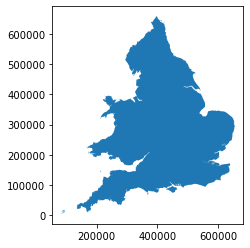

In [4]:
# Generate the boundary for EW
EW = gpd.GeoDataFrame(gpd.GeoSeries(data=msoas_EW.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
EW['geometry'] = EW.original.buffer(250)
EW = EW.set_geometry('geometry')
EW.plot()

In [5]:
# Check London MSOAs
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])
msoas.head()

,MSOA11CD,geometry
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18..."
1,E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,"POLYGON ((549102.438 189324.625, 548954.517 18..."
3,E02000004,"POLYGON ((551550.056 187364.705, 551478.000 18..."
4,E02000005,"POLYGON ((549099.634 187656.076, 549161.375 18..."


In [6]:
# Read in the listings data
url = 'https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings.csv.gz?raw=true'
cols = ['host_total_listings_count','room_type','longitude','latitude','price']
df = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=cols)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,120 x 5


In [7]:
# Convert listings from dataframe to geodataframe
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df.longitude,
                                  df.latitude, 
                                  crs="EPSG:4326"))
gdf = gdf.to_crs("EPSG:27700")

In [8]:
# Aggregate Listings by MSOA
# ml == MSOA Listings
ml = gpd.sjoin(gdf,
              msoas,
              op="within").drop(
                    columns=['latitude','longitude','index_right'])

In [9]:
# Aggregate hosts with the same listings count by MSOA
# mlgc == msoa listings grouped counts
mlgc = ml.groupby(["MSOA11CD","host_total_listings_count"])['price'].agg(Count='count').reset_index()
mlgc.head()

,MSOA11CD,host_total_listings_count,Count
0,E02000001,0,43
1,E02000001,1,92
2,E02000001,2,39
3,E02000001,3,23
4,E02000001,4,19


In [10]:
# Make use of the pivot table function to generate counts by MSOA in 'wide' format
mlgc = mlgc.pivot(index="MSOA11CD",
                 columns=["host_total_listings_count"],
                 values=["Count"]).reset_index()
mlgc.head()

MSOA11CD Count                                \
host_total_listings_count                0     1     2     3     4     5   
0                          E02000001 43.00 92.00 39.00 23.00 19.00 11.00   
1                          E02000002  2.00  3.00   NaN   NaN  1.00  4.00   
2                          E02000003  2.00 13.00  5.00  3.00   NaN   NaN   
3                          E02000004  1.00   NaN   NaN   NaN   NaN   NaN   
4                          E02000005  3.00  2.00  6.00   NaN   NaN   NaN   

                                            ...                              \
host_total_listings_count     6     7    8  ... 301 333 369 458 706 750 813   
0                         24.00 17.00 1.00  ... NaN NaN NaN NaN NaN NaN NaN   
1                           NaN   NaN  NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2                           NaN   NaN  NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3                           NaN   NaN  NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4                           NaN   NaN  NaN  ... NaN NaN NaN NaN NaN NaN NaN   

                                         
host_total_listings_count 838 1111 1309  
0                         NaN 2.00  NaN  
1                         NaN  NaN  NaN  
2                         NaN  NaN  NaN  
3                         NaN  NaN  NaN  
4                         NaN  NaN  NaN  

[5 rows x 115 columns]

In [11]:
# Drop level 0 index
mlgc.columns = mlgc.columns.droplevel(0)
cols = mlgc.columns.values
cols[0]  = 'MSOA11CD'
mlgc.columns = cols
mlgc.head()

,MSOA11CD,0,1,2,3,4,5,6,7,8,...,301,333,369,458,706,750,813,838,1111,1309
0,E02000001,43.00,92.00,39.00,23.00,19.00,11.00,24.00,17.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN
1,E02000002,2.00,3.00,NaN,NaN,1.00,4.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E02000003,2.00,13.00,5.00,3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E02000004,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E02000005,3.00,2.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Reset index
mlgc = mlgc.set_index('MSOA11CD')
mlgc.head()

,0,1,2,3,4,5,6,7,8,9,...,301,333,369,458,706,750,813,838,1111,1309
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000001,43.00,92.00,39.00,23.00,19.00,11.00,24.00,17.00,1.00,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN
E02000002,2.00,3.00,NaN,NaN,1.00,4.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,2.00,13.00,5.00,3.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,3.00,2.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2) Define and map five professionalisation levels

In [13]:
# Select 1-5 host listings as the first group
mlgc1 = mlgc.iloc[:,1:6]
mlgc1.head()

,1,2,3,4,5
MSOA11CD,,,,,
E02000001,92.00,39.00,23.00,19.00,11.00
E02000002,3.00,NaN,NaN,1.00,4.00
E02000003,13.00,5.00,3.00,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN
E02000005,2.00,6.00,NaN,NaN,NaN


In [14]:
# Calculate the sum of 1-5 host listings and define it as lower_level_prof(essionalisation)
mlgc1['lower_level_prof'] = mlgc1.apply(lambda x: x.sum(), axis=1)

cols = mlgc1.iloc[:,0:5]
mlgc1 = mlgc1.drop(columns=cols)
mlgc1.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,lower_level_prof
MSOA11CD,
E02000001,184.00
E02000002,8.00
E02000003,21.00
E02000004,0.00
E02000005,8.00


In [15]:
# Select 6-20 host listings as the second group
mlgc2 = mlgc.iloc[:,6:21]
mlgc2.head()

,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
MSOA11CD,,,,,,,,,,,,,,,
E02000001,24.00,17.00,1.00,2.00,8.00,3.00,1.00,4.00,4.00,2.00,22.00,NaN,3.00,NaN,NaN
E02000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Calculate the sum of 6-20 host listings and define it as moderate_level_prof(essionalisation)
mlgc2['moderate_level_prof'] = mlgc2.apply(lambda x: x.sum(), axis=1)

cols2 = mlgc2.iloc[:,0:15]
mlgc2 = mlgc2.drop(columns=cols2)
mlgc2.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,moderate_level_prof
MSOA11CD,
E02000001,91.00
E02000002,0.00
E02000003,0.00
E02000004,0.00
E02000005,1.00


In [17]:
# Select 21-50 host listings as the third group
mlgc3 = mlgc.iloc[:,21:51]
mlgc3.head()

,21,22,23,24,25,26,27,28,29,30,...,41,42,43,44,45,46,47,48,49,50
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000001,NaN,1.00,1.00,NaN,1.00,5.00,1.00,1.00,2.00,1.00,...,NaN,NaN,6.00,11.00,6.00,NaN,NaN,1.00,NaN,NaN
E02000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Calculate the sum of 21-50 host listings and define it as middle_level_prof(essionalisation)
mlgc3['middle_level_prof'] = mlgc3.apply(lambda x: x.sum(), axis=1)

cols3 = mlgc3.iloc[:,0:30]
mlgc3 = mlgc3.drop(columns=cols3)
mlgc3.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,middle_level_prof
MSOA11CD,
E02000001,58.00
E02000002,0.00
E02000003,1.00
E02000004,0.00
E02000005,0.00


In [19]:
# Select 51-100 host listings as the fourth group
mlgc4 = mlgc.iloc[:,51:76]
mlgc4.head()

,51,52,53,56,57,58,59,60,61,62,...,69,72,81,82,84,88,89,91,92,93
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000001,NaN,3.00,NaN,NaN,NaN,NaN,6.00,10.00,3.00,6.00,...,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Calculate the sum of 51-100 host listings and define it as higher_level_prof(essionalisation)
mlgc4['higher_level_prof'] = mlgc4.apply(lambda x: x.sum(), axis=1)

cols4 = mlgc4.iloc[:,0:25]
mlgc4 = mlgc4.drop(columns=cols4)
mlgc4.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,higher_level_prof
MSOA11CD,
E02000001,37.00
E02000002,0.00
E02000003,0.00
E02000004,0.00
E02000005,0.00


In [21]:
# Select >100 host listings as the fifth group
mlgc5 = mlgc.iloc[:,76:]
mlgc5.head()

,101,104,111,115,116,122,124,125,127,133,...,301,333,369,458,706,750,813,838,1111,1309
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000001,8.00,NaN,3.00,NaN,NaN,NaN,26.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN
E02000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Calculate the sum of >100 host listings and define it as severe_level_prof(essionalisation)
mlgc5['severe_level_prof'] = mlgc5.apply(lambda x: x.sum(), axis=1)

cols5 = mlgc5.iloc[:,0:38]
mlgc5 = mlgc5.drop(columns=cols5)
mlgc5.head()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,severe_level_prof
MSOA11CD,
E02000001,39.00
E02000002,0.00
E02000003,0.00
E02000004,0.00
E02000005,0.00


In [23]:
# Merge them all together
prof_level1 = pd.merge(mlgc1,
                       mlgc2,
                      left_index=True,
                       right_index=True)
prof_level2 = pd.merge(prof_level1,
                      mlgc3,
                      left_index=True,
                       right_index=True)
prof_level3 = pd.merge(prof_level2,
                      mlgc4,
                      left_index=True,
                       right_index=True)
prof_level4 = pd.merge(prof_level3,
                      mlgc5,
                      left_index=True,
                       right_index=True)
prof_level4.head()

,lower_level_prof,moderate_level_prof,middle_level_prof,higher_level_prof,severe_level_prof
MSOA11CD,,,,,
E02000001,184.00,91.00,58.00,37.00,39.00
E02000002,8.00,0.00,0.00,0.00,0.00
E02000003,21.00,0.00,1.00,0.00,0.00
E02000004,0.00,0.00,0.00,0.00,0.00
E02000005,8.00,1.00,0.00,0.00,0.00


In [24]:
# Add geometry column and set geometry for mapping
prof_level4 = pd.merge(prof_level4,
                      msoas,
                      left_index=True,
                      right_on='MSOA11CD').set_index('MSOA11CD')
prof_level4 = prof_level4.set_geometry('geometry')
prof_level4.head()

,lower_level_prof,moderate_level_prof,middle_level_prof,higher_level_prof,severe_level_prof,geometry
MSOA11CD,,,,,,
E02000001,184.00,91.00,58.00,37.00,39.00,"POLYGON ((532135.138 182198.131, 532158.250 18..."
E02000002,8.00,0.00,0.00,0.00,0.00,"POLYGON ((548881.563 190845.265, 548881.125 19..."
E02000003,21.00,0.00,1.00,0.00,0.00,"POLYGON ((549102.438 189324.625, 548954.517 18..."
E02000004,0.00,0.00,0.00,0.00,0.00,"POLYGON ((551550.056 187364.705, 551478.000 18..."
E02000005,8.00,1.00,0.00,0.00,0.00,"POLYGON ((549099.634 187656.076, 549161.375 18..."


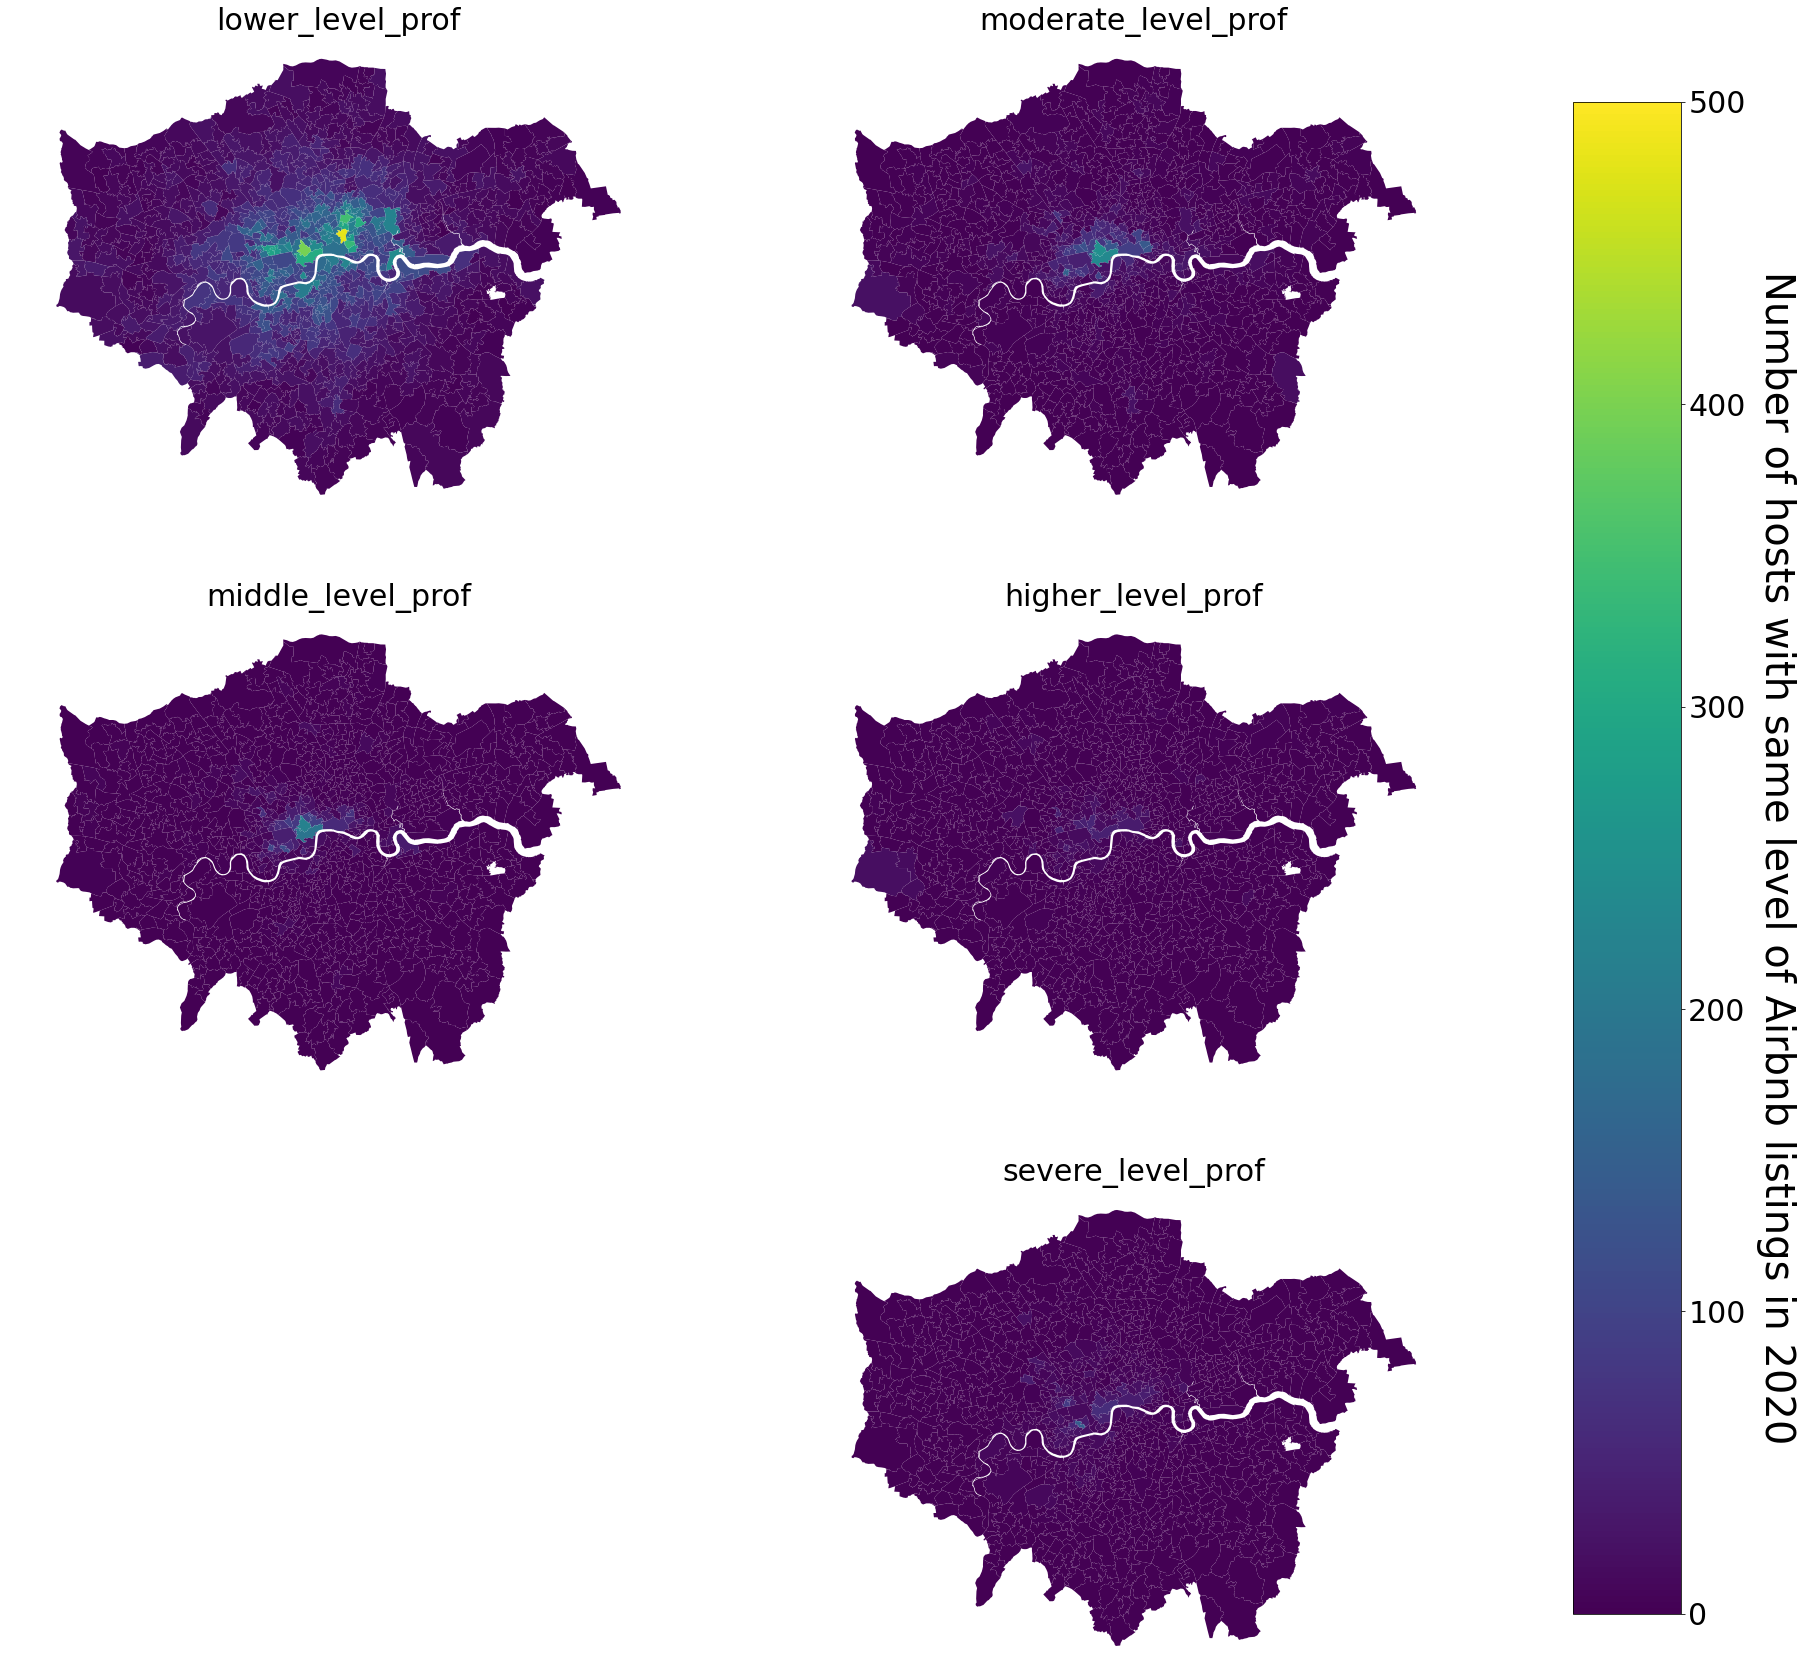

In [25]:
# Map five levels of professionalisation

# extract the column that we don't want to plot
not_plot = ["geometry"]
# use this to extract the columns that we do want to plot
to_plot = [col for col in prof_level4.columns if col not in not_plot]

# create a subplot axis, given that we have 5 different categories this has to be a 3 by 2 matrix of plots
fig, axis = plt.subplots(3,2, figsize = (30,30))
# flatten the axis so that we can iterate over them
axis = axis.flatten()

# creating the plot function
# use the enumerate to get the value and its index
for i, col in enumerate(to_plot):
    # set the axis as in the rows
    ax = axis[i]
    # to make it cleaner move two axis across
    if i >=4:
        ax = axis[i+1]
    # plot the map using the viridis color map
    list_plt = prof_level4.plot(column = col, ax=ax, cmap = "viridis", vmin =0, vmax = 500)
    # remove the axis so that it looks cleaner
    ax.set_axis_off()
    # set the plot title as the column name
    ax.set_title(col, fontsize = 30)

# adding a color bar for the overall plot
# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
vmin, vmax = 0,500
# create a subaxis within the figure
fig = ax.get_figure()
plt.subplots_adjust(right = 0.8)
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7], label = "Number of hosts")
# create a colorbar and plot it
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = fig.colorbar(sm, cax=cax)
# change the size of the tick parameters
cb.ax.tick_params(labelsize = 30)
# set the label title
# https://stackoverflow.com/questions/17475619/how-do-i-adjust-offset-colorbar-title-in-matplotlib
cb.set_label("Number of hosts with same level of Airbnb listings in 2020", rotation = 270, fontsize= 40, labelpad = 50)

# remove axis of plot not covered
axis[4].set_axis_off()

# show the results
plt.show()

# save figure
fig.savefig('Number of hosts with same level of Airbnb listings in 2020.png', dpi=150)

From this plot we can have two key take-aways: Firstly, 5 levels of professionalization are all mainly concentrated in the central of London, which make sense since most airbnb listings are tourist-targeted in London. Secondly, lower level professionalization appears to have the greatest hosts number, resulting from existing supervision. What this could mean for our clustering algorithm is that, since clustering can be influenced strongly by differing variance between factors, the algorithm may be likely to focus on lower level professionalization. This could potentially be controlled by standardising/ rescaling, such as putting each number of hosts for each professionalisation level on a 0 to 1 scale, which would in theory put all values on the same range and prepare them ready for clustering.

### 3) Transform data for clustering

First check the distribution of 5 groups of number of hosts with same level of Airbnb listings which we will use for clustering.

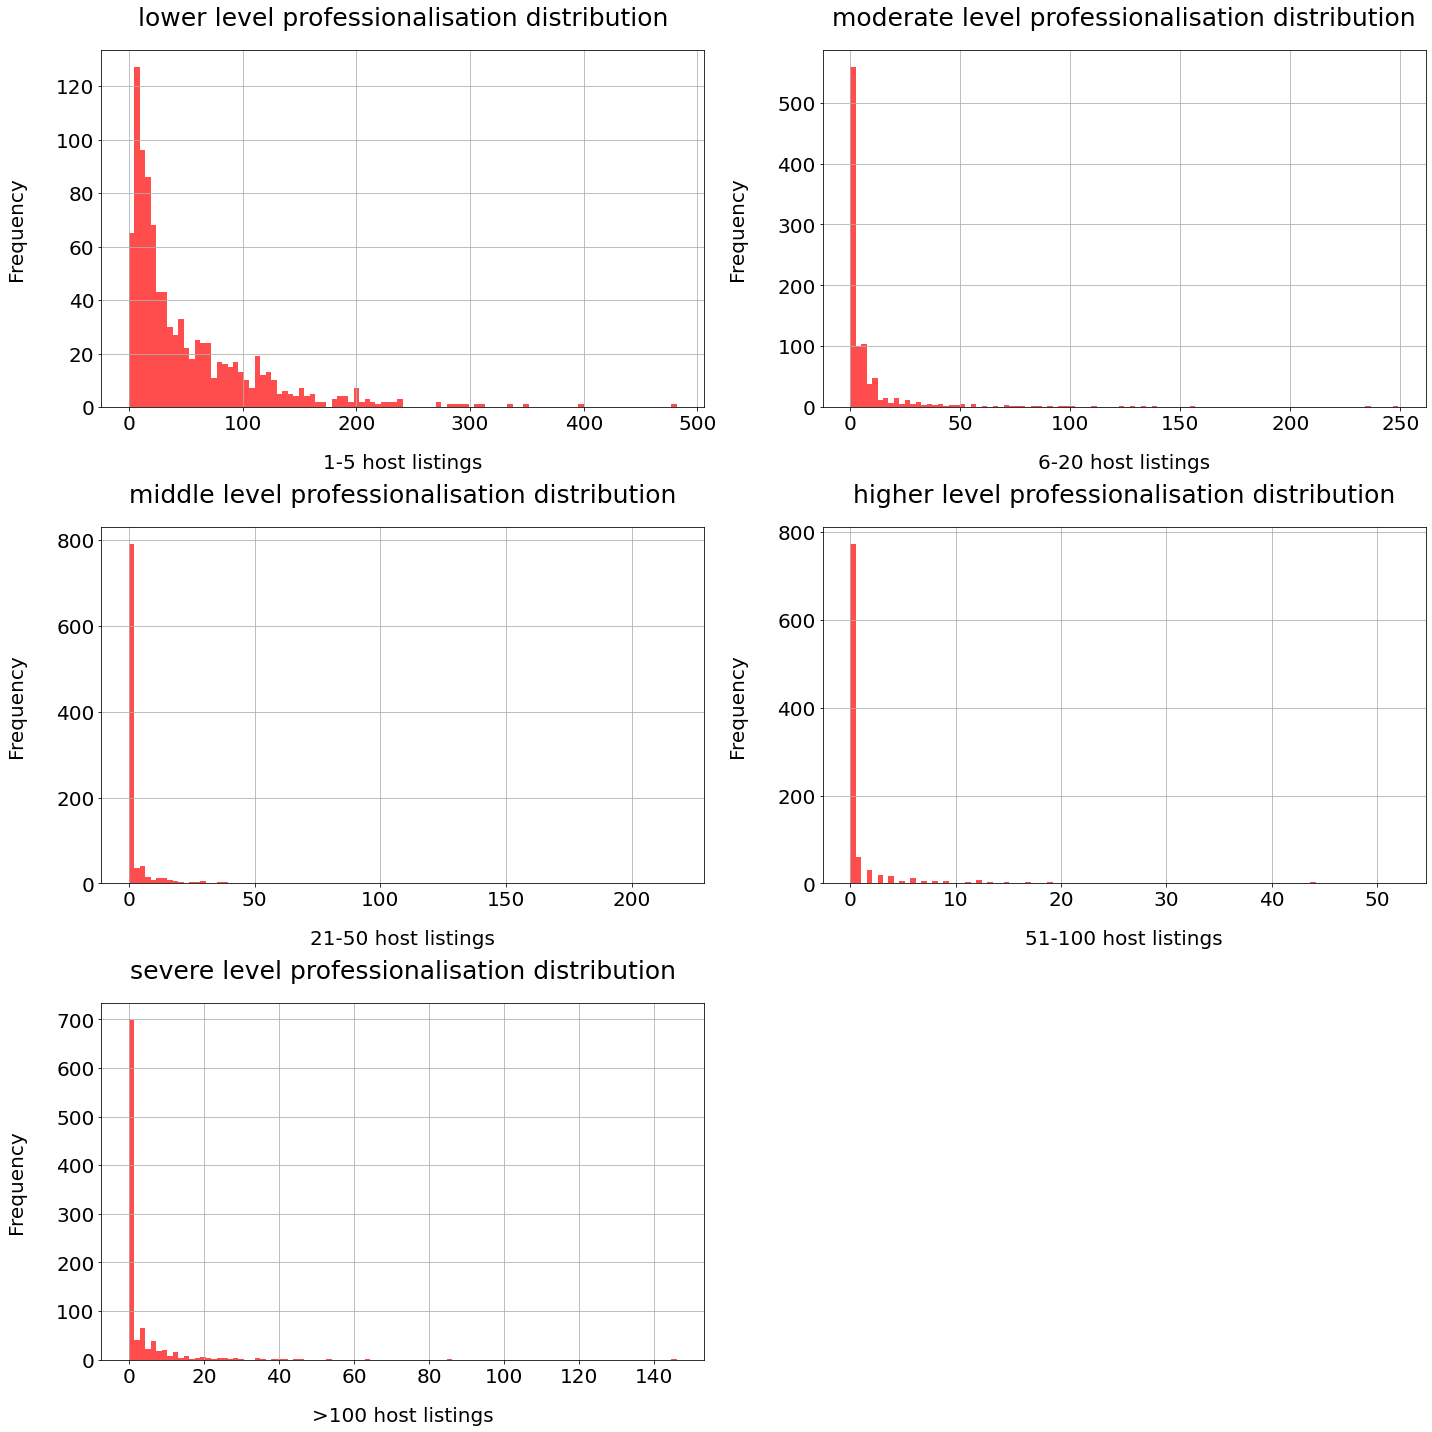

In [26]:
# set the columns we are interested in
columns = ["lower_level_prof", 
            "moderate_level_prof",
            "middle_level_prof",
            "higher_level_prof",
            "severe_level_prof"]
# set the histogram titles
hist_titles = ["lower level professionalisation distribution",
              "moderate level professionalisation distribution",
              "middle level professionalisation distribution",
              "higher level professionalisation distribution",
              "severe level professionalisation distribution"]
# set the axis labels
axis_labels = ["1-5 host listings", 
              "6-20 host listings",
              "21-50 host listings",
              "51-100 host listings",
              ">100 host listings"]

# create a base axis for the plots
fig, ax = plt.subplots(3,2, figsize = (20,20))
# flatten the axis to make it easy to iterate over
axis = ax.flatten()

# iterate over each columns using the labels information already set up
for i, col in enumerate(columns):
    
    # create the histogram using the column
    prof_level4[col].hist(bins = 100, ax = axis[i],
                                       color = "red",
                                       alpha = 0.7)
    # add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20)

# remove the unused axis
axis[5].set_axis_off()
# keep the layout tight
plt.tight_layout()
# show the plot 
plt.show()

# save the plot
fig.savefig('Number of hosts with same level of Airbnb listings distribution in 2020.png', dpi=150)

We can see here that the variables are not well normally distributed, but having a degree of positive skew.

In [27]:
# understand the data distribution to see if there will be any issues in transformation
prof_level4[["lower_level_prof",
             "moderate_level_prof",
             "middle_level_prof",
             "higher_level_prof",
             "severe_level_prof"]].describe()

,lower_level_prof,moderate_level_prof,middle_level_prof,higher_level_prof,severe_level_prof
count,980.00,980.00,980.00,980.00,980.00
mean,52.63,7.74,3.77,1.51,3.00
std,59.03,19.69,14.23,5.33,8.48
min,0.00,0.00,0.00,0.00,0.00
25%,12.00,0.00,0.00,0.00,0.00
50%,29.00,2.00,0.00,0.00,0.00
75%,73.25,7.00,1.00,0.00,2.00
max,482.00,249.00,218.00,52.00,146.00


First take natural logarithm for the data to tackle skewness.

In [28]:
# Take natural logarithm for the data
# iterate over the columns
for col in columns:
    # create a new log column and convert the data
    prof_level4[col + "_log"] = np.log10(prof_level4[col] + 1)
    # some issues are encountered so convert these to 0 values 
    prof_level4[col + "_log"] = prof_level4[col + "_log"].replace([np.inf, -np.inf], 0)

Then rescale the data using Robust scaler which is more appropriate compared with other types of scaler when dealing with data containg many outliers.

In [29]:
# Rescale the data
scaled = prof_level4[["lower_level_prof_log",
                      "moderate_level_prof_log",
                      "middle_level_prof_log",
                      "higher_level_prof_log",
                      "severe_level_prof_log"]].copy()

# use the robust scaler
rc = RobustScaler()

# implement the scaling
for col in scaled.columns:
    scaled[col] = rc.fit_transform(scaled[col].values.reshape(-1,1))
    
# create a dataframe from the data
log_then_normal = pd.DataFrame(scaled)

# set the columns
log_columns = ["lower_level_prof_log",
               "moderate_level_prof_log",
               "middle_level_prof_log",
               "higher_level_prof_log",
               "severe_level_prof_log"]

# set the column names
log_then_normal.columns = log_columns

# add this to a scaled dataset to be used in modelling
prof_level4_scaled = pd.concat([prof_level4.drop(log_columns, axis = 1), 
                                              log_then_normal], 
                                             axis = 1)

Plot to check the distribution of the data after taking natural logarithm and then rescaling.

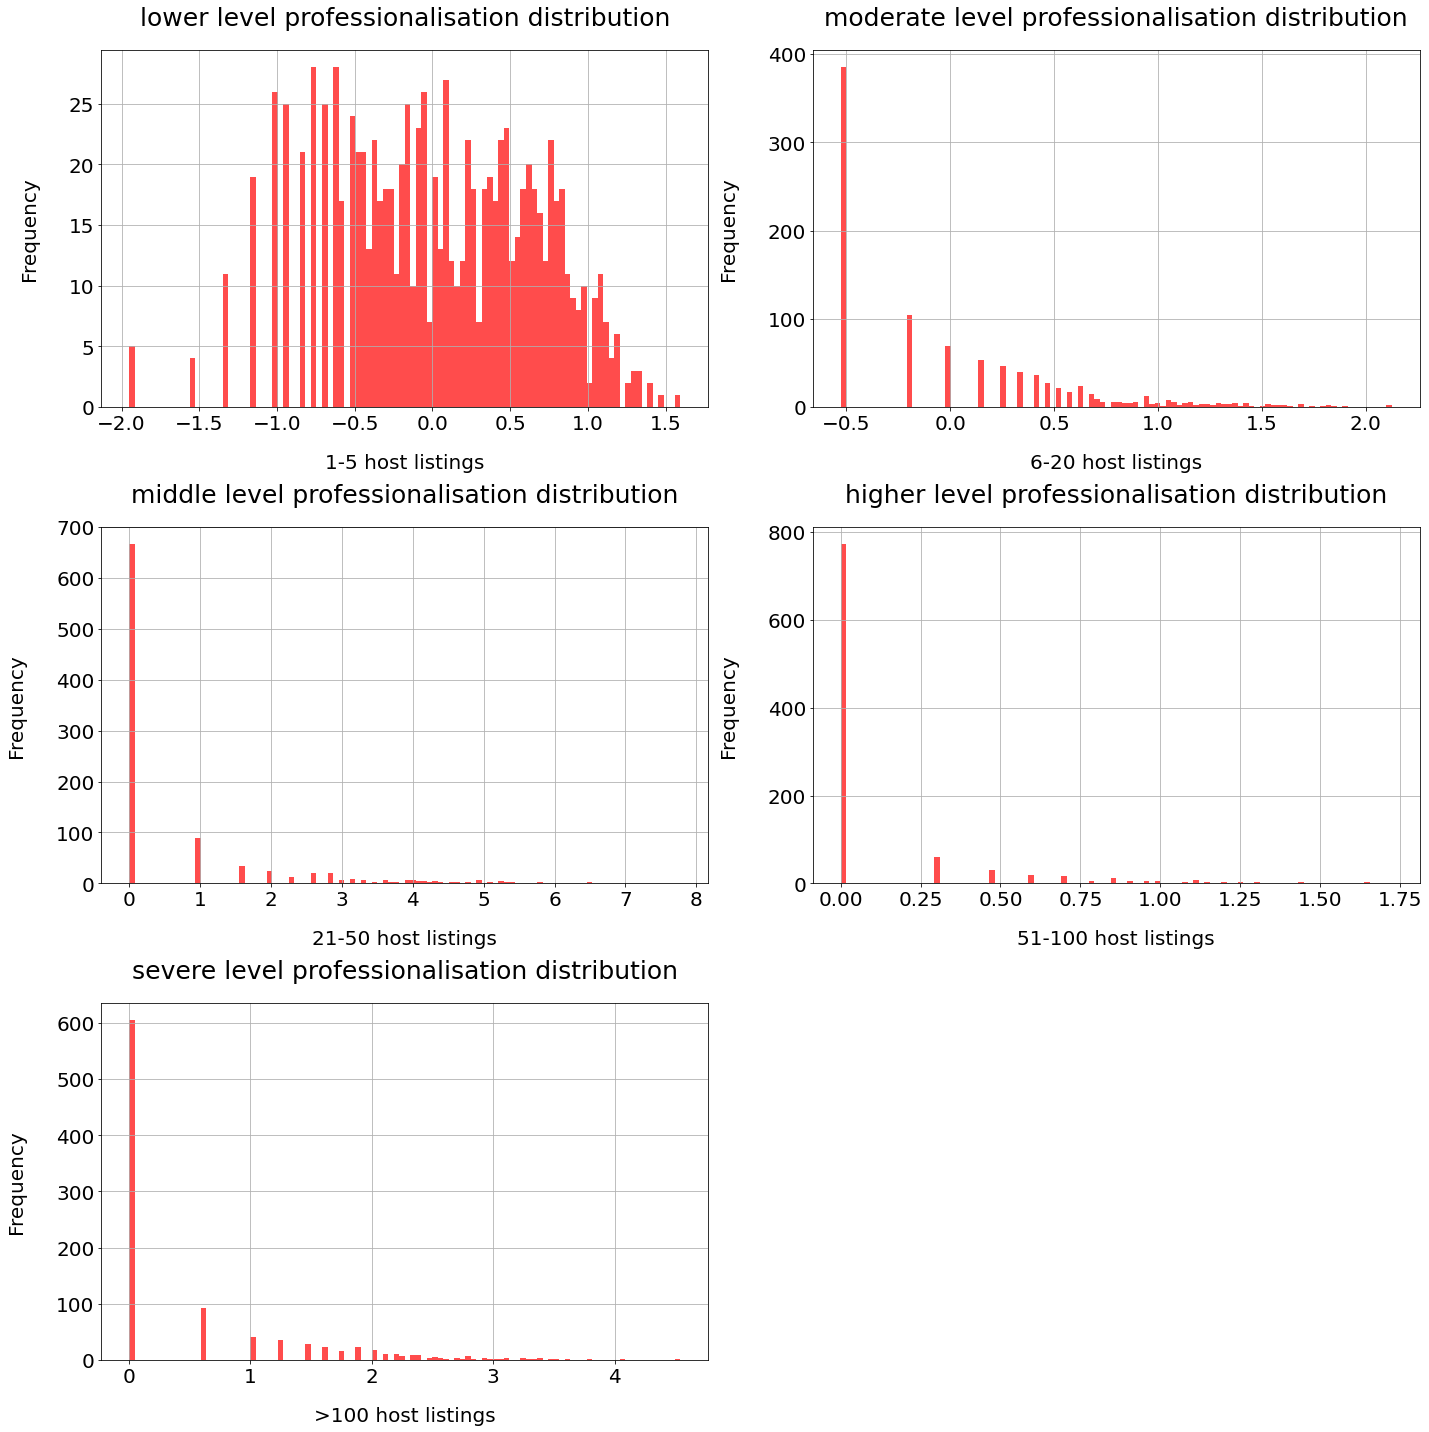

In [30]:
# create a base axis for the plots
fig, ax = plt.subplots(3,2, figsize = (20,20))
# flatten the axis to make it easy to iterate over
axis = ax.flatten()

# iterate over each columns using the labels information already set up
for i, col in enumerate(log_columns):
    
    # create the histogram using the column
    prof_level4_scaled[col].hist(bins = 100, ax = axis[i],
                                       color = "red",
                                       alpha = 0.7)
    # add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20)

# remove the unused axis
axis[5].set_axis_off()
# keep the layout tight
plt.tight_layout()
# show the plot 
plt.show()

# save the plot
fig.savefig('Number of hosts with same level of Airbnb listings distribution in 2020 (log and rescale).png', dpi=150)

### 4) Perform Silhouette and Elbow Analysis

Using the rescaled data, perform silhouette and elbow analysis on the data to find the optimal number of clusters to implement in the final model.

In [31]:
# Calculate the SEE score
# create an empty list
list_SSE = []
# set the range of clusters to evaluate
min_k = 1
max_k = 20
range_k = range(min_k, max_k)

# iterate over the range
for i in range_k:
    # perform the clustering algorithm
    km = KMeans(n_clusters = i,
               init = "random",
               n_init = 10,
               max_iter = 300,
               tol = 1e-04, 
                random_state = 22)
    # fit this to the data
    km.fit(prof_level4_scaled[log_columns])
    # add the SEE score
    list_SSE.append(km.inertia_)

In [32]:
# Calculate the silhouette score
# create an empty list
silhouette = []

# iteratre over the number of clusters to evaluate
for i in range(2,20):
    
    # create an empty list to hold the averages
    average = []
    # perform the clustering algorithm several times for each number of clusters
    for x in range(1,20):
        # set the number of clusters
        k_cluster = i
        # generate a random seed number
        random_seed = random.randint(1,101)
        # apply the KMeans clustering algorithm
        kmeans_method = KMeans(n_clusters = k_cluster,
                              random_state = random_seed)
        kmeans_method.fit(prof_level4_scaled[log_columns])
        # extract the labels
        labels = kmeans_method.labels_
        # extract the silhouette score
        a = metrics.silhouette_score(prof_level4_scaled[log_columns], labels)
        # append the result
        average.append(a)
    # calculate the average silhouette score for each number of clusters 
    silhouette.append(sum(average)/len(average))

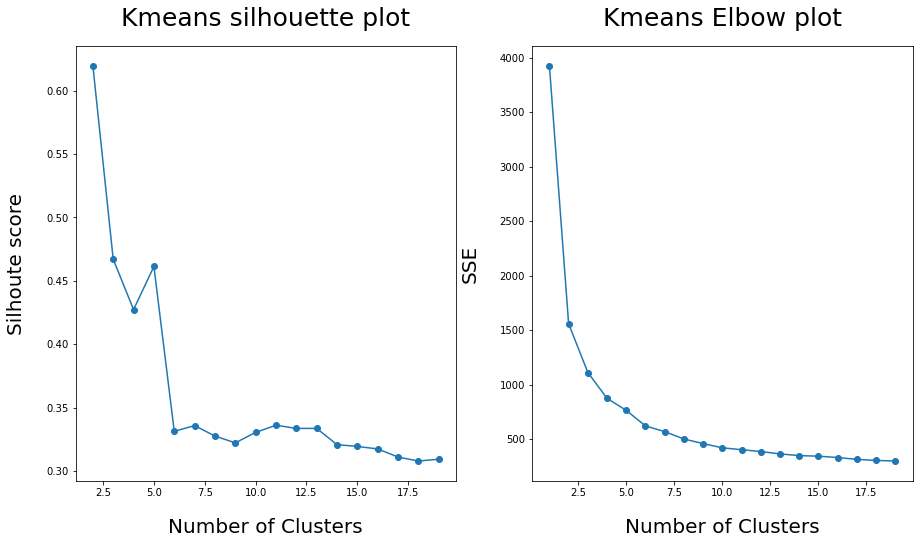

In [33]:
# Combine both plots
fig, ax = plt.subplots(1,2, figsize = (15,8))

ax[0].plot(range(2,20), silhouette, marker = "o")
ax[0].set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax[0].set_ylabel("Silhoute score", fontsize =20, labelpad = 20)
ax[0].set_title("Kmeans silhouette plot", fontsize = 25, pad = 20)

ax[1].plot(range_k, list_SSE, marker = "o")
ax[1].set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
ax[1].set_ylabel("SSE", fontsize =20, labelpad = 20)
ax[1].set_title("Kmeans Elbow plot", fontsize = 25, pad = 20)

# Save the plots
fig.savefig('Silhouette and Elbow plot.png', dpi=150)

The optimal number of clusters to implement with this dataset that these two plots suggest to use is five clusters (both high silhouette score and around the elbow in the elbow plot).

### 5) Select the most appropriate clusters number and check the results

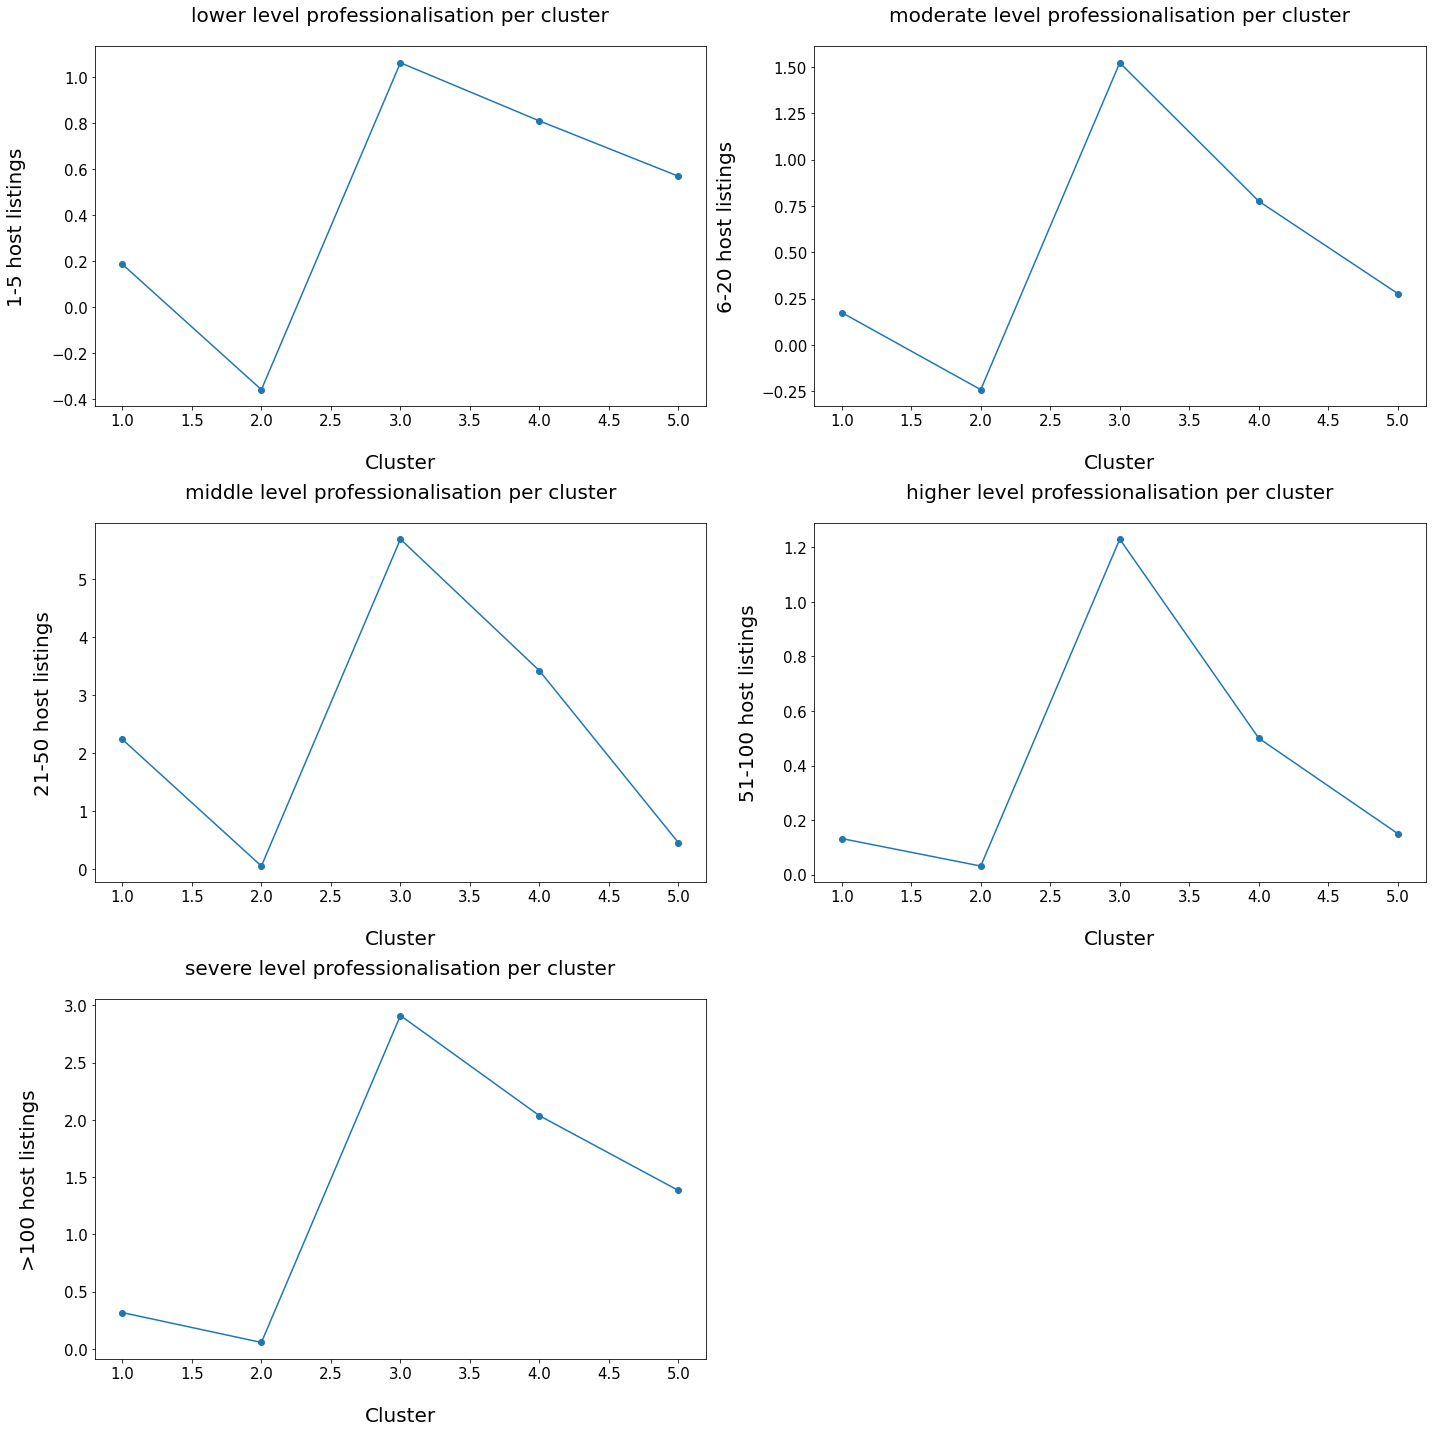

In [34]:
# perform the clustering with the chosen number of clusters
kmeans_method = KMeans(n_clusters = 5,
                       random_state = 22,
                       n_init = 10)
kmeans_method.fit(prof_level4_scaled[log_columns])


# creating plots for the results to understand the means

# set the titles
titles = ["lower level professionalisation per cluster",
          "moderate level professionalisation per cluster",
          "middle level professionalisation per cluster",
          "higher level professionalisation per cluster",
          "severe level professionalisation per cluster"]
# set the labels
ylabels = ["1-5 host listings",
           "6-20 host listings",
           "21-50 host listings",
           "51-100 host listings",
           ">100 host listings"]
# extract the cluster labels and add these back to the data
labels = kmeans_method.labels_
prof_level4_scaled["labels"] = labels
prof_level4_scaled["labels"] = prof_level4_scaled["labels"] + 1

# create a base plot
fig, ax = plt.subplots(3,2, figsize = (20,20))
# flatten the axis
axis = ax.flatten()

# iterate over each column to create plots for each 
for i, col in enumerate(log_columns):
    # create an empty dictionary
    col_dict = {}
    # iterate over each label
    for label in list(prof_level4_scaled["labels"].unique()):
        # crete a new dataframe for each label
        label_df = prof_level4_scaled[prof_level4_scaled["labels"] == label]
        # add the mean to the dataframe
        col_dict[label] = label_df[col].mean()
    # convert the dictionary to a dataframe
    column_df = pd.DataFrame.from_dict(col_dict, orient = "index")
    # reset the index
    column_df.reset_index(inplace=True)
    # sort the values by the index
    column_df.sort_values(by = "index", inplace=True)
    
    # plot the results
    axis[i].plot(column_df["index"], column_df[0],
                marker = "o")
    
    # set the plots up
    axis[i].set_title(titles[i], fontsize = 20, pad = 25)
    axis[i].set_xlabel("Cluster", fontsize = 20, labelpad = 25)
    axis[i].set_ylabel(ylabels[i], fontsize =20, labelpad = 25)
    axis[i].tick_params(axis = "both", labelsize = 15)

# remove the unused axis
axis[5].set_axis_off()

# set the layout to tight so no overlap
plt.tight_layout()

# save the plots
fig.savefig('The means of each cluster.png', dpi=150)

In [35]:
# extract the number of MSOAs within each cluster
prof_level4_scaled["labels"].value_counts()

2    605
5    163
4     99
1     78
3     35
Name: labels, dtype: int64

### 6) Final K-Means results map

Now prepare to create the final K-Means results map, first install some fonts.

In [36]:
# install fonts
loc = mpl.get_cachedir()
!ls {loc}
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

fontlist-v330.json


Then map!

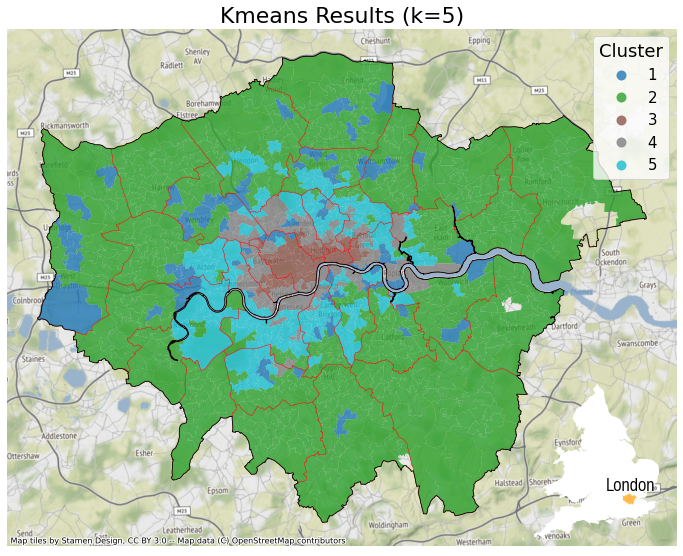

In [37]:
# create the base axis
fig, ax = plt.subplots(1,1, figsize = (12,12))

# add the labels
prof_level4_scaled.plot(column='labels',
                        categorical = True,
                        legend = True,
                        ax = ax,
                        cmap = "tab10",
                        alpha = 0.8,
                        legend_kwds = {"title":"Cluster",
                                       "fontsize":"15",
                                       "title_fontsize":"18"})

# plot the boroughs
boroughs.boundary.plot(ax = ax,
                       facecolor = None,
                       edgecolor = "r",
                       linewidth=0.3)
# plot the outline
London_outline.boundary.plot(ax = ax,
                             color = "black",
                             linewidth=0.8)

# add the basemap
cx.add_basemap(crs = "EPSG:27700",
              ax = ax)

ax.set_axis_off()

# add inset map
ax2 = fig.add_axes([0.7, 0.2, 0.2, 0.2])
EW.plot(facecolor='white', edgecolor='None', ax=ax2)
msoas.plot(facecolor='orange', edgecolor='None', ax=ax2)
ax2.axis('off')
ax2.set_title('London', x=0.6, y=0.3, color = "black", size=18, **tfont)

# add the title
ax.set_title(f"Kmeans Results (k=5)", fontsize=22, y=1)

# and save
fig.savefig('Kmeans results.png', dpi=150)

## Acknowledgements

Besides codes built upon those provided in CASA0013 FSDS practicals, many codes above are built upon codes in clustering workshop repositories from our gifted and helpful PGTA Philip Wilkinson. The codes in clustering workshop repositories in Philip's GitHub are neat and handy, from which I have learnt a lot and built up clearer understanding of connotation, application and result interpretation of clustering analysis. Thank you for your tutorial in CASA0013 and sharing topics and approaches on those interesting and insightful spatial data science researches that you have carried out lately with us, which are really inspiring!

### Sources

- Kmeans clustering workshop - [PhilipDW183/Kmeans-clustering-workshop](https://github.com/PhilipDW183/Kmeans-clustering-workshop)
- Hierarchical clustering workshop - [PhilipDW183/hierarchical_clustering](https://github.com/PhilipDW183/hierarchical_clustering)
- Convenience store clusters - [PhilipDW183/Convenience_store](https://github.com/PhilipDW183/Convenience_store)
- London crime clusters - [PhilipDW183/London_crime_clusters](https://github.com/PhilipDW183/London_crime_clusters)